# Recognition of Gestures and Actions
- 사람의 Body Points(관절)을 감지하여 제스쳐와 동작을 구분하자

### 사용 데이터셋 MPII Human Pose Dataset : http://human-pose.mpi-inf.mpg.de/
- MPII Model: 인간의 움직임을 인식하도록 특별히 학습된 모듈 (유튜브 영상을 추출해서 학습했다.)
  - VGG 아키텍쳐(합성곱 신경망)를 사용하여 구성된다.
  - MPII와 이미지넷 데이터셋의 차이는 MPII는 사람의 포인트를 감지하고 이미지셋은 객체의 클래스를 분류하는것이다.
  - 추출 할 수 있는 인간의 body points 주로 사용하는건 0~15번까지이다. (원래는 더 있다.)
    - 0은 머리, 1은 목, 2는 오른쪽 어깨등 사람의 주요 관절을 감지하여 행동을 파악한다.

## Detecting Body Points

### Importing the libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### Loading the image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Images/megan.jpg')

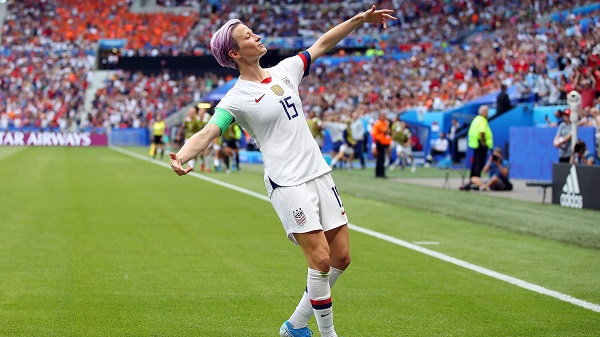

In [4]:
cv2_imshow(image)

In [5]:
# 이미지 shape, 전체 픽셀개수
image.shape, image.shape[0] * image.shape[1]* 3

((337, 600, 3), 606600)

### 이미지 모델에 전송하기(Blob)

 - 이미지를 모델에 전송하기위해 blob형식으로 바꿔야한다.
  - .blob: blob 형식은 바이너리 형식으로 큰 객체 ( 비디오, 이미지, 사운드 같은)를 저장하는 방식이다. 탄생 배경은 DB에서 정의되지 않은 형식의 데이터를 저장하기 위해 만들어진 형식이다. 기본적으로 용량이 큰 파일들은 여러 페이지(page,운영체제)로 나누어져서 저장되어지는것 보단 연결되어 관리되어지는게 편해서 blob을 사용하면 그것이 가능하다.
  - 딥러닝에선 이미지를 입력층으로 보낼때 주로 사용하는데 이진 데이터로 이미지의 픽셀 값, 크기, 채널 수를 관리하여 효율적으로 사용할수 있기때문이다.

In [6]:
type(image)

numpy.ndarray

In [7]:
# cv2.dnn.blobFromImage 이미지를 blob형식으로 변환
# 매개변수 : image- 이미지파일, scalefactor - 정규화 방식 , size=(너비,높이)
# Mean subtraction
image_blob = cv2.dnn.blobFromImage(image = image, scalefactor = 1.0/255,
                                   size = (image.shape[1],image.shape[0]))

In [8]:
# type은 같지만 shape이 이미지개수, 채널수, 높이, 너비로 바꼈다.
type(image_blob), image_blob.shape

(numpy.ndarray, (1, 3, 337, 600))

### Loading the pre-trained neural network
- 사전 학습된 모델 가져오기 caffe 프레임워크(darknet과 비슷한것)
- Caffe Deep Learning framework: https://caffe.berkeleyvision.org/

In [10]:
# cv2.dnnreadNetFrom 함수에는 caffe, tensorflow, darknet등 다양한 딥러닝 프레임워크에서 만든 구조를 형식에 맞춰 cv2에서 사용할 수 있도록 변환해주는 함수이다.
# 대부분 매개변수는 ('신경망 구조 파일 경로', '가중치 파일 경로') 이다. caffe는 신경망 구조가 .prototxt 형식 가중치 구조가 .caffemodel 이다.
# cv2에 사전 학습된 신경망 이식
network = cv2.dnn.readNetFromCaffe("/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/pose_deploy_linevec_faster_4_stages.prototxt",
                                   "/content/drive/MyDrive/Colab Notebooks/Project/Computer Vision/src/Weights/pose_iter_160000.caffemodel")



In [11]:
network.getLayerNames() # 각각의 층의 이름을 출력

('conv1_1',
 'relu1_1',
 'conv1_2',
 'relu1_2',
 'pool1_stage1',
 'conv2_1',
 'relu2_1',
 'conv2_2',
 'relu2_2',
 'pool2_stage1',
 'conv3_1',
 'relu3_1',
 'conv3_2',
 'relu3_2',
 'conv3_3',
 'relu3_3',
 'conv3_4',
 'relu3_4',
 'pool3_stage1',
 'conv4_1',
 'relu4_1',
 'conv4_2',
 'relu4_2',
 'conv4_3_CPM',
 'relu4_3_CPM',
 'conv4_4_CPM',
 'relu4_4_CPM',
 'conv5_1_CPM_L1',
 'relu5_1_CPM_L1',
 'conv5_1_CPM_L2',
 'relu5_1_CPM_L2',
 'conv5_2_CPM_L1',
 'relu5_2_CPM_L1',
 'conv5_2_CPM_L2',
 'relu5_2_CPM_L2',
 'conv5_3_CPM_L1',
 'relu5_3_CPM_L1',
 'conv5_3_CPM_L2',
 'relu5_3_CPM_L2',
 'conv5_4_CPM_L1',
 'relu5_4_CPM_L1',
 'conv5_4_CPM_L2',
 'relu5_4_CPM_L2',
 'conv5_5_CPM_L1',
 'conv5_5_CPM_L2',
 'concat_stage2',
 'Mconv1_stage2_L1',
 'Mrelu1_stage2_L1',
 'Mconv1_stage2_L2',
 'Mrelu1_stage2_L2',
 'Mconv2_stage2_L1',
 'Mrelu2_stage2_L1',
 'Mconv2_stage2_L2',
 'Mrelu2_stage2_L2',
 'Mconv3_stage2_L1',
 'Mrelu3_stage2_L1',
 'Mconv3_stage2_L2',
 'Mrelu3_stage2_L2',
 'Mconv4_stage2_L1',
 'Mrelu4_sta

In [12]:
len(network.getLayerNames())

127

### Predicting body points
- 이미지를 신경망에 입력하여 결과 얻기

In [13]:
# 이전에 변환한 blob형식의 이미지를 모델의 인풋레이어에 전송
network.setInput(image_blob)
# 예측 실행(tensorflow predict()와 유사, cv2에선 forward()를 쓴다)
output = network.forward()

In [15]:
output.shape # ('이미지 번호', 'body point', 'height', 'width')

(1, 44, 43, 75)

In [16]:
position_width = output.shape[3]
position_height = output.shape[2]

In [19]:
position_width

75

In [36]:
num_points = 15 # body point 번호(0~14까지)
points = []
threshold = 0.1
for i in range(num_points):
  # output은 4개의 차원이있다.(1, 44, 43, 75), output[]을 슬라이싱하면 각각의 차원에 접근할 수 있다
  # [[0,i, :, :]]는 0번째 이미지에서 i번째 bodypoint에 각각의 width,height의 확률들을 가져오겠다.
  confidence_map = output[0,i, :, :]
  # 43개의 높이마다 75개의 너비가 있고 각각의 너비들이 해당 bodypoint가 될 확률을 값으로 가지고있다
  # 이미지 높이 1:[이미지 너비1:[이미지 높이 1,이미지 너비 1 일때 bodypoint일 확률],이미지 너비2:[이미지 높이 1,이미지 너비 2 일때 bodypoint일 확률]]
  # 이미지 높이 2:[이미지 너비1:[이미지 높이 2,이미지 너비 1 일때 bodypoint일 확률],이미지 너비2:[이미지 높이 2,이미지 너비 2 일때 bodypoint일 확률]]
  # 이미지 높이와 너비가 기존보다 달라진 이유는 신경망에서 이미지의 크기를 변환하기 때문이다 -> 실제 이미지에 적용하기 위해 다시 알맞은 변형해야한다.
  print(confidence_map.shape)
  print(confidence_map)
  print(len(confidence_map))
  _, confidence, _, point = cv2.minMaxLoc(confidence_map)

  x= int((image.shape[1] * point[0]) / position_width)
  y = int((image.shape[0] * point[1]) / position_height)
  if confidence  > threshold:
    cv2.circle(image, (x,y), 5, (0,255,0))
    cv2.putText(image, '{}'.format(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255))
    points.append((x,y))
  else:
    points.append(None)

(43, 75)
[[0.00055962 0.00058117 0.00053579 ... 0.00046494 0.00052144 0.00070126]
 [0.00056341 0.00061412 0.00052243 ... 0.00043261 0.00049986 0.00065831]
 [0.00053554 0.00056641 0.00048143 ... 0.00043169 0.00049813 0.00059231]
 ...
 [0.00054603 0.0005327  0.00055443 ... 0.0004957  0.00050947 0.00049164]
 [0.00056263 0.00054248 0.00058617 ... 0.00050225 0.00053838 0.00052778]
 [0.00057272 0.00055983 0.00060435 ... 0.00051735 0.00056315 0.00057202]]
43
(43, 75)
[[0.00111267 0.00121808 0.00114181 ... 0.00090227 0.00107411 0.00183264]
 [0.00109335 0.00143293 0.00105185 ... 0.00084134 0.0009794  0.00163178]
 [0.00112441 0.00127547 0.00095223 ... 0.0008397  0.00097065 0.00120474]
 ...
 [0.00107108 0.00105736 0.00109277 ... 0.00099074 0.00102576 0.0009806 ]
 [0.00115377 0.00106191 0.00114098 ... 0.00097911 0.00106342 0.00103366]
 [0.00112932 0.00109654 0.00118373 ... 0.00100781 0.00110869 0.00112275]]
43
(43, 75)
[[0.00060168 0.00077594 0.00064453 ... 0.00041856 0.00069521 0.00212016]
 [0.00

In [37]:
points

[(224, 23),
 (248, 62),
 (232, 94),
 (208, 125),
 (176, 148),
 (280, 62),
 (320, 39),
 (360, 15),
 (288, 180),
 (320, 250),
 (320, 321),
 (312, 164),
 (336, 250),
 (296, 305),
 (280, 125)]

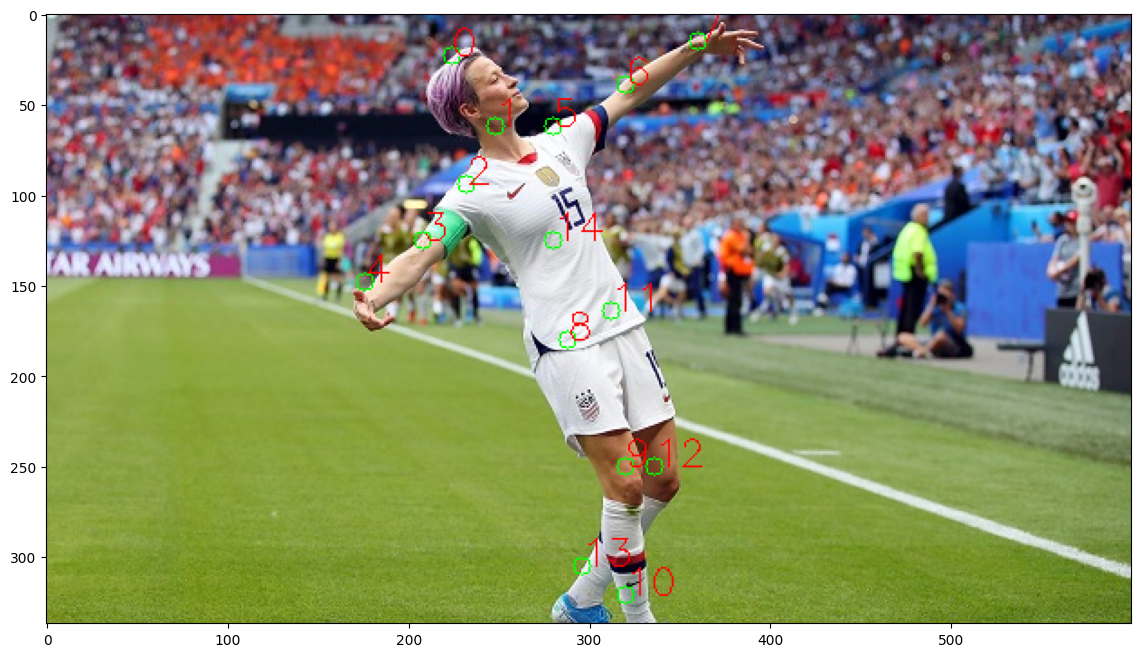

In [38]:
plt.figure(figsize = (14,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))